# Variational AutoEncoders (VAE)
In this notebook, we will cover VAEs to learn the distribution of the FashionMNIST and be able to generate clothe variation.

## Imports

In [1]:
import torch
import os
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.transforms import ToTensor, Lambda, Grayscale, Compose, Resize
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST, ImageFolder
from matplotlib import pyplot as plt
import torchvision.utils as vutils
import numpy as np
import pickle as pkl



import numpy as np

%matplotlib inline

In [2]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
batch_size = 256
IMGS_TO_VISUALIZE = 4
d = 20 # Latent Dimension
dataset_path = "../data" 

# Set random seeds for reproducibility

torch.manual_seed(1)
torch.cuda.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Helpers

In [3]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, IMG_HEIGHT, IMG_WIDTH)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, IMG_HEIGHT, IMG_WIDTH)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

## Loading Fashion MNIST

In [4]:
train_loader = torch.utils.data.DataLoader(
    FashionMNIST(dataset_path, train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    FashionMNIST(dataset_path, train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

## Defining VAE

In [10]:
class VAE(nn.Module):
    def __init__(self, img_width, img_height):
        super().__init__()
        
        self.img_width = img_width
        self.img_height = img_height

        self.encoder = nn.Sequential(
            nn.Linear(img_width * img_height, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, img_width * img_height),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        
        x = x.view(-1, self.img_width * self.img_height) # Flatten in case it is not already
        
        mu_logvar = self.encoder(x)        
        mu_logvar = mu_logvar.view(-1, 2, d) # divide dimensions to get mu and variance # [batch_size, d * 2] -> [batch_size, 2, d] 
        mu = mu_logvar[:, 0, :] # mean
        logvar = mu_logvar[:, 1, :] # variance
        
        z = self.reparameterise(mu, logvar) # create the latent representation based on mu and variance
        
        return self.decoder(z), mu, logvar

In [11]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

model = VAE(IMG_WIDTH,IMG_HEIGHT).to(device)
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

## Training VAE on FMNIST

### Custom Loss function for VAE

In [12]:
def loss_function(x_hat, x, mu, logvar):
    
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, IMG_WIDTH * IMG_HEIGHT), reduction='sum'
    )
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL-Divergence loss

    return BCE + KLD

In [13]:
def train(num_epochs = 5):
    
    imgs = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
        
        # Testing
    
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for x, _ in test_loader:
                x = x.to(device)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                test_loss += loss_function(x_hat, x, mu, logvar).item()
                
        # ===================log========================
        test_loss /= len(test_loader.dataset)
        print(f'====> Test set loss: {test_loss:.4f}')
          
        # Print imgs if wanted
        x_hat = x_hat.view(-1, 1, IMG_HEIGHT, IMG_WIDTH)
        imgs.append(torch.cat([x[:IMGS_TO_VISUALIZE], x_hat[:IMGS_TO_VISUALIZE]], dim = 0))
    
    concat_imgs = torch.cat([tens for tens in imgs])
    return mu, logvar, x, concat_imgs

====> Epoch: 0 Average loss: 302.3409
====> Test set loss: 266.1949
====> Epoch: 1 Average loss: 263.5427
====> Test set loss: 255.7810
====> Epoch: 2 Average loss: 256.5198
====> Test set loss: 249.9376
====> Epoch: 3 Average loss: 252.6231
====> Test set loss: 247.4738
====> Epoch: 4 Average loss: 249.9591
====> Test set loss: 245.0248
====> Epoch: 5 Average loss: 248.2724
====> Test set loss: 243.5758
====> Epoch: 6 Average loss: 246.9957
====> Test set loss: 242.4707
====> Epoch: 7 Average loss: 246.0780
====> Test set loss: 242.6325
====> Epoch: 8 Average loss: 245.3330
====> Test set loss: 241.6963
====> Epoch: 9 Average loss: 244.6978
====> Test set loss: 240.2950
====> Epoch: 10 Average loss: 244.2195
====> Test set loss: 240.6481
====> Epoch: 11 Average loss: 243.7911
====> Test set loss: 239.1232
====> Epoch: 12 Average loss: 243.4701
====> Test set loss: 239.5956
====> Epoch: 13 Average loss: 243.0439
====> Test set loss: 238.4384
====> Epoch: 14 Average loss: 242.7870
====>

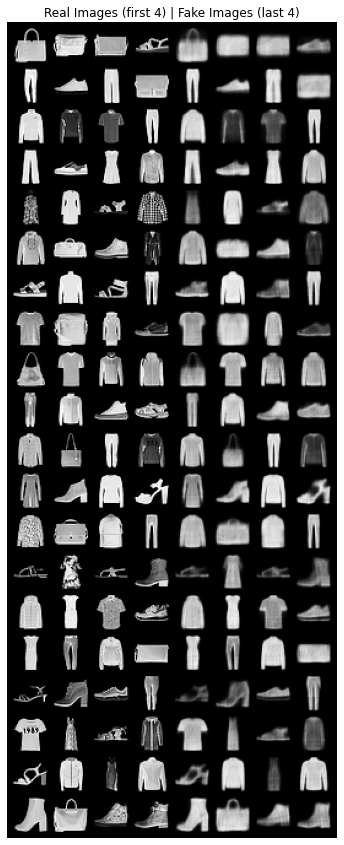

In [14]:
mu, logvar, x, imgs = train(20) # Get mu, variance, and last input to the network to test after!

# Plot what was generated and what 

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images (first 4) | Fake Images (last 4)")
plt.imshow(np.transpose(vutils.make_grid(imgs, padding=5, normalize=True, nrow=IMGS_TO_VISUALIZE * 2).cpu(),(1,2,0))) 

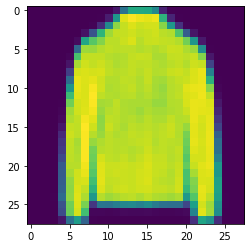

In [135]:
with torch.no_grad():
    model.eval()
    pt1 = model(imgs[20])[0].view(-1, 1, IMG_HEIGHT, IMG_WIDTH).squeeze().cpu()
    plt.imshow(pt1)

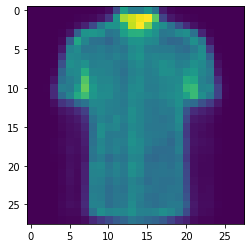

In [136]:
with torch.no_grad():
    model.eval()
    pt2 = model(imgs[22])[0].view(-1, 1, IMG_HEIGHT, IMG_WIDTH).squeeze().cpu()
    plt.imshow(pt2)

In [143]:
ratios = np.linspace(0, 1, num=10)
vectors = list()
for ratio in ratios:
    v = (1.0 - ratio) * pt1 + ratio * pt2
    vectors.append(v)
interpolated = np.asarray(vectors)

C:\Users\ngrec\AppData\Local\Temp\ipykernel_23128\1635050535.py:6: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  interpolated = np.asarray(vectors)
C:\Users\ngrec\AppData\Local\Temp\ipykernel_23128\1635050535.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  interpolated = np.asarray(vectors)


In [144]:
# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	plt.show()

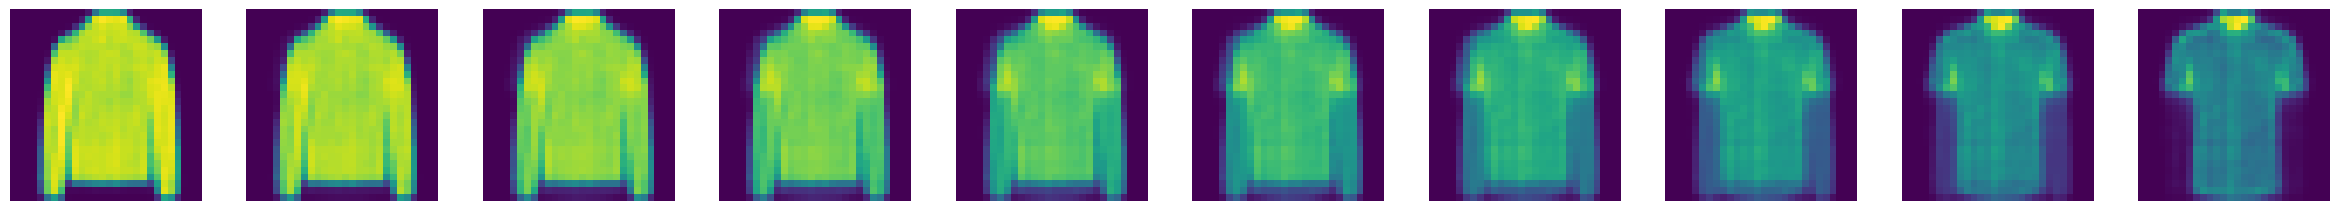

In [148]:
plt.figure(figsize=(30, 30), dpi=100)
plot_generated(interpolated, len(interpolated))

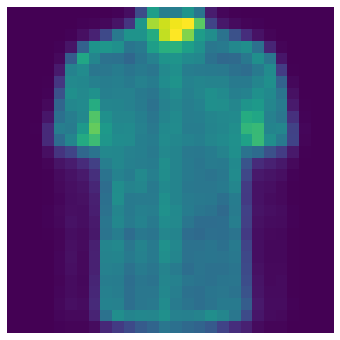

In [145]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(6,6))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in interpolated]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [160]:
f = r"./animation.gif" 
writergif = animation.PillowWriter(fps=30) 
ani.save(f, writer=writergif)